In [162]:
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix, csr_matrix
from scipy.spatial.distance import jaccard, cosine 
import pandas as pd
import re


In [163]:
from keras.callbacks import EarlyStopping
from pathlib import Path
import tifffile as tiff
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Masking

In [164]:
sample_sub= pd.read_csv("/Users/kevinwalker/Downloads/nlp-getting-started/sample_submission.csv")

In [165]:
test= pd.read_csv("/Users/kevinwalker/Downloads/nlp-getting-started/test.csv")

In [166]:
train= pd.read_csv("/Users/kevinwalker/Downloads/nlp-getting-started/train.csv")

WRITE UP

STEP 1: The problem is to use a matrix factoriziation and a sequential nueral network application to classify tweets into disaster related tweets or not disster related tweets.  We will be training on about 7k tweets to then predict aout 3200. There are some identical helper columns with keyword and location to help classify. 

Step 2 EDA, I did some regular info and head on the test and train data.  Then created some histograms and stacked bars centered around the keywords as well as locations to see which keywords or locations lean towards others. I also performed some stop words by grabbing the most common. My plan is to remove a reasonable amount of stop words. before pushing it through the RNN.

STEP 3: for model architecture post scrubbing stop words...Post tokenizing at 50 tokens per tweet and with a mini word2vec formula using a normal distribution to vectorize the tokens and to factorize the data and add 100 dimensions. I realize that 50 tokens were way too many given the sizes of most tweets and that 50 dimensions was too many. I then went down to 15 and saw a huge leap in performace. After tokenizing and vectorizing i built a bi directional GRU model with only the vectorized text. In all models I played with different return sequences gathering either each step or just the final thought as a whole.  I also tired to add the keywords to the model by transforming them into a number and concatenating them in the end of the model before the result.

STEP 4 my after fitting to just the cleaned & vectorizezd train text i saw a very tight band of my sigmoid acitvation.  I learned that this is because i had too many zeros in the tokenizing part. After shorting the tokens I saw my accuracy go up to about 2/3. which i wanted to improve. I experimented with longer epochs which saw some marginal improvemnts.  Then I attempeted to assign numerical values to the keywords and locations as those also could give direction to whether a tweet was a disaster or not. This was tough and had to concatenate after a few layers of the model. This however did increase my accuracy quite a bit to 74%

Step 5:  I think having a digestable number of parameters is key.  When i have too many and learning rate is slow it takes the model a long time to improve and eats away and my cpu & gpu.  I learned that having a validation data set is also beneficial.  As my model would have just fit tighter and tighter but having an early stop on the validation data prevented an over fit and potentially bad test results.  Also using drop out and fewer tokens /due to size of tweets greatly improved run time and accuracy.  I think starting with a smaller model (in parameters) would help me learn more about what improvements i could make instead of having a large churn and losing hours while model trying to converage. 

In [324]:
print(sample_sub.head(25))
print(sample_sub.info())

    id  target
0    0       0
1    2       0
2    3       0
3    9       0
4   11       0
5   12       0
6   21       0
7   22       0
8   27       0
9   29       0
10  30       0
11  35       0
12  42       0
13  43       0
14  45       0
15  46       0
16  47       0
17  51       0
18  58       0
19  60       0
20  69       0
21  70       0
22  72       0
23  75       0
24  84       0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3263 non-null   int64
 1   target  3263 non-null   int64
dtypes: int64(2)
memory usage: 51.1 KB
None


In [168]:
#FIND DATA INFO ON TEST NOTICED SOMEKEYWORD AND LOCATIONS ARE BLANK

print(test.head())
print(test.info())
print(test['keyword'].unique())

   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None
[nan 'ablaze' 'accident' 'aftershock' 'airplane%20accident' 'ambulance'
 'annihilated' 'annihilation' 'apocalypse' 'armageddon' 'army' 'arson'
 'arsonist' 'attack' '

In [169]:
print(test['location'].unique())

[nan 'London' "Niall's place | SAF 12 SQUAD |" ...
 'Acey mountain islanddåÇTorontoåÈ' 'los angeles' 'Brussels, Belgium']


In [191]:
#LEARNED KEYWORDS ARE IN ORDER OF THE ID
print(train[200:215])

      id      keyword                   location  \
200  281    ambulance  VISIT MY YOUTUBE CHANNEL.   
201  283    ambulance                  Lexington   
202  285    ambulance                        NaN   
203  287    ambulance                        USA   
204  289    ambulance          Hannover, Germany   
205  290    ambulance                        NaN   
206  291    ambulance                        NaN   
207  293    ambulance                      Playa   
208  294    ambulance               Davidson, NC   
209  296  annihilated              Higher Places   
210  297  annihilated              Horsemind, MI   
211  298  annihilated               New York, NY   
212  299  annihilated                   Boksburg   
213  301  annihilated                        NaN   
214  302  annihilated                        NaN   

                                                  text  target  keyword_int  \
200  HAPPENING NOW - HATZOLAH EMS AMBULANCE RESPOND...       0    ambulance   
201  http

([<matplotlib.axis.XTick at 0x3d34dfc20>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

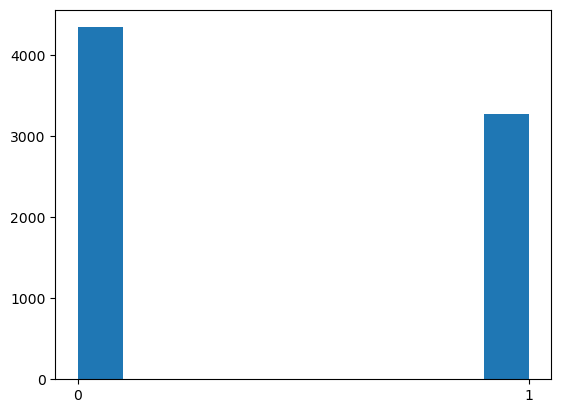

In [172]:
#TARGET CLASS WEIGHT MOSTLY NON DISATER RELATED

plt.hist(train['target'])
plt.xticks([0,1])

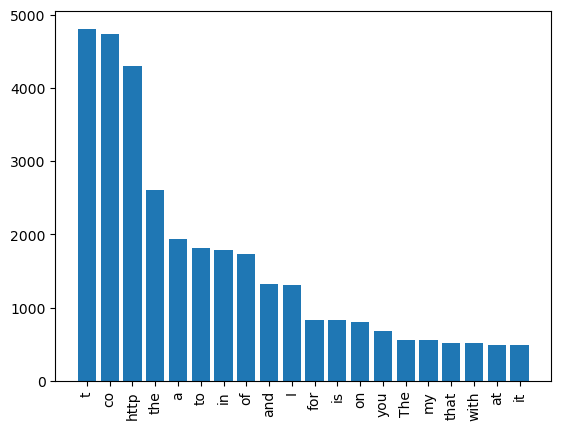

In [173]:
#FINDING STOP WORDS IN TRAIN DATA TO CLEAN THEM OUT
uniquewords =train['text'].str.findall(r"[a-z']+", flags=re.IGNORECASE).explode()
uw = uniquewords.value_counts().head(20)
stop = uw.index
plt.bar(range(len(uw)),uw)
plt.xticks(range(len(uw)),uw.index,rotation =90)
plt.show()

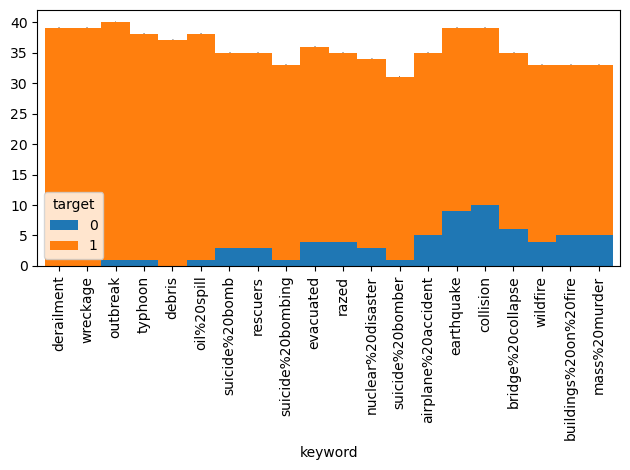

In [174]:
#LOOKING AT KEYWORDS AND HOW THEY INCLUENCED TARGET
ct = pd.crosstab(train['keyword'], train['target']).reindex(columns=[0,1], fill_value=0)
ct = ct.sort_values(1, ascending=False).head(20)
ax = ct.plot(kind='bar', stacked=True, width=1)
tot = ct.sum(1)
for i,v in enumerate(tot): ax.text(i, v, int(v), ha='center', va='bottom', fontsize=.1)
plt.tight_layout(w_pad =100); plt.show()
# used google ai search and https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_stacked.html```

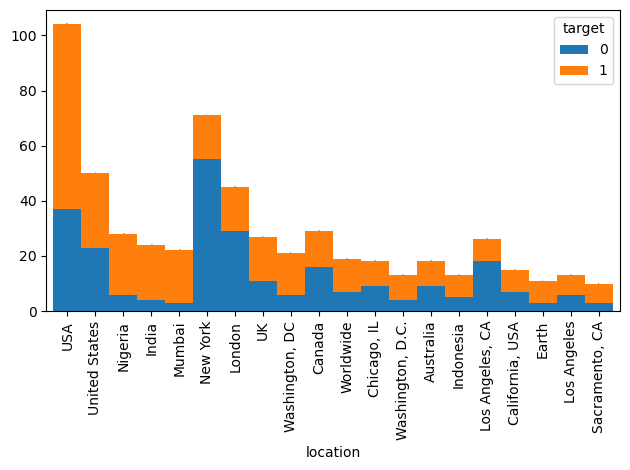

In [175]:
#LOOKING AT LOCATION TO SEE HOW THEY INFLUENCED TARGET
ct = pd.crosstab(train['location'], train['target']).reindex(columns=[0,1], fill_value=0)
ct = ct.sort_values(1, ascending=False).head(20)
ax = ct.plot(kind='bar', stacked=True, width=1)
tot = ct.sum(1)
for i,v in enumerate(tot): ax.text(i, v, int(v), ha='center', va='bottom', fontsize=.1)
plt.tight_layout(w_pad =100); plt.show()
# used google ai search and https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_stacked.html

In [245]:
#NUMERIZE TRAIN KEYWORDS AND LOCATIONS
keyword_int= train['keyword'].replace('',pd.NA)
indk, uniquek = pd.factorize(keyword_int,use_na_sentinel=-1)
keyword_int_id = indk.reshape(-1,1)
print(keyword_int_id.shape)

location_int= train['location'].replace('',pd.NA)
indl, uniquel = pd.factorize(location_int,use_na_sentinel=-1)
location_int_id = indl.reshape(-1,1)
print(location_int_id.shape)

(7613, 1)
(7613, 1)


In [246]:
#MAPPING TEST KEYWORDS AND LOCATIONS TO THEIR TRAIN NUMBER
test_location_int= test['location'].replace('',pd.NA)
test_location_int_id = pd.Categorical(test_location_int, categories= uniquel).codes.reshape(-1,1)
print(test_location_int_id.shape)
test_keyword_int= test['keyword'].replace('',pd.NA)
test_keyword_int_id = pd.Categorical(test_keyword_int, categories= uniquek).codes.reshape(-1,1)
print(test_keyword_int_id.shape)

(3263, 1)
(3263, 1)


In [325]:
#CLEANING STOP WORDS FROM TRAIN AND TEST 'TEXT'
train_clean = train['text'].apply(lambda x: ' '.join([w for w in x.split() if w not in (stop)]))
test_clean = test['text'].apply(lambda x:' '.join([w for w in x.split() if w not in (stop)]))

In [208]:
print(train_clean[:12])
print(test_clean[:12])

0     Our Deeds are Reason this #earthquake May ALLA...
1                Forest fire near La Ronge Sask. Canada
2     All residents asked 'shelter place' are being ...
3     13,000 people receive #wildfires evacuation or...
4     Just got sent this photo from Ruby #Alaska as ...
5     #RockyFire Update => California Hwy. 20 closed...
6     #flood #disaster Heavy rain causes flash flood...
7                    I'm top hill can see fire woods...
8     There's an emergency evacuation happening now ...
9                 I'm afraid tornado coming our area...
10              Three people died from heat wave so far
11    Haha South Tampa getting flooded hah- WAIT A S...
Name: text, dtype: object
0                      Just happened terrible car crash
1     Heard about #earthquake different cities, stay...
2     there forest fire spot pond, geese are fleeing...
3              Apocalypse lighting. #Spokane #wildfires
4                Typhoon Soudelor kills 28 China Taiwan
5                    W

Tokenizing the train clean list and then doing a Word to Vec method I saw googling

In [330]:
tok1= Tokenizer(num_words = 50000)

In [331]:
train_clean_list= train_clean.tolist()
test_clean_list = test_clean.tolist()
keyword_clean_list= train['keyword'].dropna(axis=0).tolist()
location_clean_list = train['location'].dropna(axis=0).tolist()
keyword_clean_list[:2]

['ablaze', 'ablaze']

In [332]:
tok1.fit_on_texts(train_clean_list)

In [333]:
sequenced =  tok1.texts_to_sequences(train_clean_list)
sequenced_test = tok1.texts_to_sequences(test_clean_list)

print(sequenced[0])
print(sequenced_test[1])

[114, 4633, 8, 868, 5, 263, 133, 1619, 4634, 81, 25]
[474, 42, 263, 1201, 2648, 605, 2321, 245]


In [334]:
x = pad_sequences(sequenced,maxlen=15,padding='post')
x_test = pad_sequences(sequenced_test,maxlen=15,padding='post')

In [335]:
print(x[0])
print(x_test[0])

[ 114 4633    8  868    5  263  133 1619 4634   81   25    0    0    0
    0]
[  19  913 1951  125   85    0    0    0    0    0    0    0    0    0
    0]


In [336]:
# simulating word 2 vector making random embedings for all words in the 15 series tokens. 
# Then gru will back propagate to align these embeding like fire close to flame close to burn

embedded_matrix = np.random.normal(0,.1,(50000,100))
embedded_matrix[0]=0
X_embed= embedded_matrix[x]
X_embed_test= embedded_matrix[x_test]

In [216]:
print(X_embed.shape)

(7613, 15, 100)


In [265]:
print(train['target'].shape)

(7613,)


In [277]:
#my early stoppinng models scored on validation auc and loss
ES = EarlyStopping(monitor = 'val_auc',patience = 5, mode ='max',restore_best_weights= True)
ES1 = EarlyStopping(monitor = 'val_loss',patience = 5, mode ='max',restore_best_weights= True)

In [ ]:
#Model with text,keywords, location

In [326]:
textT=keras.Input(shape=(15,100),name = 'X_embed')
kwt =keras.Input(shape=(1,),name= 'keyword_int_id')
loct=keras.Input(shape=(1,),name= 'location_int_id')



In [257]:
x = layers.GRU(64,return_sequences = True, recurrent_dropout=.1)(textT)

In [258]:
gruout =layers.GRU(64,return_sequences = False,recurrent_dropout=.1)(x)

In [259]:
x= layers.Concatenate()([gruout,kwt,loct])

In [260]:
xout=(layers.Dense(1,activation='sigmoid'))(x)

In [261]:
GRU_model =keras.Model(inputs=[textT,kwt,loct],outputs=xout)

In [262]:
GRU_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ X_embed             │ (None, 15, 100)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_18 (GRU)        │ (None, 15, 64)    │     31,872 │ X_embed[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_19 (GRU)        │ (None, 64)        │     24,960 │ gru_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keyword_int_id      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ location_int_id     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 66)        │          0 │ gru_19[0][0],     │
│ (Concatenate)       │                   │            │ keyword_int_id[0… │
│                     │                   │            │ location_int_id[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1)         │         67 │ concatenate_6[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,899 (222.26 KB)

 Trainable params: 56,899 (222.26 KB)

 Non-trainable params: 0 (0.00 B)

In [263]:
GRU_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',keras.metrics.AUC(name='auc')])

In [267]:
GRU_model.fit([X_embed,keyword_int_id,location_int_id],train['target'],epochs=30,batch_size =64,callbacks=ES,validation_split=.17)

Epoch 1/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 76s 737ms/step - accuracy: 0.5158 - auc: 0.4949 - loss: 4.6086 - val_accuracy: 0.5127 - val_auc: 0.5456 - val_loss: 5.5303
Epoch 2/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 72s 728ms/step - accuracy: 0.5369 - auc: 0.5386 - loss: 1.4197 - val_accuracy: 0.5127 - val_auc: 0.6760 - val_loss: 1.8081
Epoch 3/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 71s 717ms/step - accuracy: 0.6016 - auc: 0.6074 - loss: 0.7124 - val_accuracy: 0.5521 - val_auc: 0.6815 - val_loss: 0.7221
Epoch 4/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 73s 740ms/step - accuracy: 0.6608 - auc: 0.6804 - loss: 0.6314 - val_accuracy: 0.6062 - val_auc: 0.6849 - val_loss: 0.6761
Epoch 5/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 74s 744ms/step - accuracy: 0.6800 - auc: 0.7046 - loss: 0.6116 - val_accuracy: 0.6185 - val_auc: 0.6673 - val_loss: 0.6595
Epoch 6/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 74s 748ms/step - accuracy: 0.6808 - auc: 0.7079 - loss: 0.6117 - val_accuracy: 0.5830 - val_auc: 0.6387 - val_loss: 0.6728
Epoch 7/30
99/99 ━━━━━━━━━━━━━━━━━

In [269]:
y_pred=GRU_model.predict([X_embed_test,test_keyword_int_id,test_location_int_id])

102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step


In [271]:
test['target'] = y_pred_int

In [270]:
print(max(y_pred))
print((y_pred)[:15])
print(y_pred.shape)
y_pred_int= (y_pred >= .50).astype(int)
print(y_pred_int.shape)

[0.99815816]
[[0.23448037]
 [0.24018662]
 [0.8746168 ]
 [0.08110038]
 [0.51514965]
 [0.39804548]
 [0.8900424 ]
 [0.04958282]
 [0.08978221]
 [0.06839608]
 [0.06406662]
 [0.08820736]
 [0.06989574]
 [0.07218827]
 [0.06872617]]
(3263, 1)
(3263, 1)


In [272]:
test[['id','target']].to_csv("testtwitteroutputk35.csv",index =False)

In [337]:
#Bidirectional model with embeded text only
textT1=keras.Input(shape=(15,100),name = 'X_embed')

In [298]:
x1 = layers.GRU(128,return_sequences = True, recurrent_dropout=.2)(textT1)

In [299]:
x1 =layers.Bidirectional(GRU(64,return_sequences = False,recurrent_dropout=.1))(x1)

In [300]:
xout1=(layers.Dense(1,activation='sigmoid'))(x1)

In [301]:
GRU_model1 =keras.Model(inputs=textT1,outputs=xout1)

In [302]:
GRU_model1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',keras.metrics.AUC(name='auc')])
GRU_model1.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ X_embed (InputLayer)            │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_28 (GRU)                    │ (None, 15, 128)        │        88,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,945 (636.50 KB)

 Trainable params: 162,945 (636.50 KB)

 Non-trainable params: 0 (0.00 B)

In [303]:
GRU_model1.fit(X_embed,train['target'],epochs=30,batch_size =64,callbacks=ES1,validation_split=.17)

Epoch 1/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.6223 - auc: 0.6458 - loss: 0.6479 - val_accuracy: 0.6579 - val_auc: 0.7093 - val_loss: 0.6286
Epoch 2/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.6744 - auc: 0.7040 - loss: 0.6147 - val_accuracy: 0.6402 - val_auc: 0.6894 - val_loss: 0.6448
Epoch 3/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.6877 - auc: 0.7283 - loss: 0.5948 - val_accuracy: 0.6054 - val_auc: 0.6793 - val_loss: 0.7052
Epoch 4/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.6996 - auc: 0.7432 - loss: 0.5797 - val_accuracy: 0.6548 - val_auc: 0.7090 - val_loss: 0.6342
Epoch 5/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.7062 - auc: 0.7533 - loss: 0.5683 - val_accuracy: 0.6324 - val_auc: 0.6947 - val_loss: 0.6587
Epoch 6/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.7149 - auc: 0.7644 - loss: 0.5608 - val_accuracy: 0.6263 - val_auc: 0.7098 - val_loss: 0.6537
Epoch 7/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/

In [304]:
y_pred1=GRU_model1.predict(X_embed_test)

102/102 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step


In [305]:
print(max(y_pred1))
print((y_pred1)[:15])
print(y_pred1.shape)
y_pred_int1= (y_pred1 >= .50).astype(int)
print(y_pred_int1.shape)

[0.98811555]
[[0.2829946 ]
 [0.28362876]
 [0.7308613 ]
 [0.26857924]
 [0.52882534]
 [0.5128384 ]
 [0.78004634]
 [0.2389996 ]
 [0.2132892 ]
 [0.36315647]
 [0.13621941]
 [0.20973642]
 [0.21879308]
 [0.17249084]
 [0.21307538]]
(3263, 1)
(3263, 1)


In [306]:
test['target'] = y_pred_int1

In [322]:
test1=(test[['id','target']])
print(test1[:10])


   id  target
0   0       0
1   2       0
2   3       1
3   9       0
4  11       1
5  12       1
6  21       1
7  22       0
8  27       0
9  29       0


In [323]:
test1.to_csv('Grubidirsub1.csv',index=False)